#Visual Odometry by using Quaternion Neural Network for AI Driving


---


*made by Alessandro Lambertini and Denise Landini*

*mat. 1938390 and 1938388*

In [ ]:
#@title {vertical-output: true, form-width: "50%", display-mode: "code"}
#@markdown # Global Variables:

#@markdown ---
#@markdown ### Flags:
FLAG_DOWNLOAD_DATASET = False #@param {type:"boolean"}
FLAG_DEBUG_PRINT = True #@param {type:"boolean"}
FLAG_INFO_PRINT = True #@param {type:"boolean"}

#@markdown ---
#@markdown ### Files path:
# global variables to save the tables/models 
dir_main = '/content/drive/My Drive/Colab Notebooks/Thesis/' #@param {type:"string"}
          #'drive/.shortcut-targets-by-id/1u8wbljmLaX2INDIFTQqsk3xLVCalv2_o/Thesis/'

dir_Dataset = 'Dataset/'#@param {type:"string"}
dir_Dataset = dir_main + dir_Dataset
dir_Model = 'Model/'#@param {type:"string"}
dir_Model = dir_main + dir_Model
dir_History = 'History/'#@param {type:"string"}
dir_History = dir_main + dir_History

#@markdown ---
#@markdown ### Images settings:
BACH_SIZE = 10 #@param {type:"number"}
CHANNELS = 6
WIDTH = 320 #@param [320, 640, 1280] {type:"raw", allow-input: false}
HEIGHT = 96 #@param[96, 192, 384] {type:"raw", allow-input: false}
NUM_POSES = 6

trainingSeries = ["00", "02", "08", "09"]
testingSeries = ["03", "04", "05", "06", "07", "10"]


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -la drive/.shortcut-targets-by-id/1u8wbljmLaX2INDIFTQqsk3xLVCalv2_o/Thesis

total 818
drwx------ 2 root root   4096 Nov 23 16:43 Dataset
-rw------- 1 root root 692858 Mar 17 13:19 deepVO.ipynb
-rw------- 1 root root  36441 Mar 20 16:44 DeepVOout.ipynb
drwx------ 2 root root   4096 Nov 23 16:43 History
drwx------ 2 root root   4096 Nov 23 16:43 Model
-rw------- 1 root root  95077 Mar 19 20:57 QuaternionDeepVO.ipynb


In [ ]:
import glob
import numpy as np
import os
import time
import math
import random

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.autograd import Variable
from torchvision import models

### Functions

In [ ]:
from IPython.display import HTML, display
def progress(value, max=100):
  return HTML("""
    <progress
        value='{value}'
        max='{max}',
        style='width: 50%'
    >
        {value}
    </progress>
  """.format(value=value, max=max))

In [ ]:
def isRotationMatrix(R):
  RT = np.transpose(R)
  n = np.linalg.norm(np.identity(3, dtype = R.dtype) - np.dot(RT, R))
  return n < 1e-6

def rotationMatrixToEulerAngles(R):
  assert(isRotationMatrix(R))

  sy = math.sqrt(R[0,0]*R[0,0] + R[1,0]*R[1,0])
  if  sy < 1e-6:
    x = math.atan2(-R[1,2], R[1,1])
    y = math.atan2(-R[2,0], sy)
    z = 0
  else:
    x = math.atan2(R[2,1] , R[2,2])
    y = math.atan2(-R[2,0], sy)
    z = math.atan2(R[1,0], R[0,0])

  return np.array([x, y, z])

def matrix2pose(mat):
  p = np.array([mat[3], mat[7], mat[11]])
  R = np.array([[mat[0], mat[1], mat[2]],
                [mat[4], mat[5], mat[6]],
                [mat[8], mat[9], mat[10]]])
  
  angles = rotationMatrixToEulerAngles(R)
  pose = np.concatenate((p, angles))
  return pose

In [ ]:
def getImage(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_LINEAR)
  return img

def loadImages(path, suffix):
  #numImgs = 0#len(os.listdir(path))
  #print("Path: ".format(path))
  #print("Num of imges {}".format(numImgs))

  initT = time.time()
  if os.path.isfile(path + suffix):
    imagesSet = np.load(path + suffix, allow_pickle=False)
    print(imagesSet.shape)
  else:
    notFirstIter = False
    img1 = []
    img2 = []
    imagesSet = []
    for img in glob.glob(path+'/*'):
      img2 = getImage(img)

      if notFirstIter:
        img = np.concatenate([img1, img2], axis=-1)
        imagesSet.append(img)
      else:
        notFirstIter = True
      
      img1 = img2
  
  elapsedT = time.time() - initT
  #print("Time needed: %.2fs"%(elapsedT))
  imagesSet = np.reshape(imagesSet, (-1, CHANNELS, WIDTH, HEIGHT))
  return imagesSet

In [ ]:
def loadPoses(path):
  #print("Path: ".format(path))

  suffix = "_pose_loaded.npy".format(WIDTH, HEIGHT)
  initT = time.time()
  if os.path.isfile(path + suffix):
    posesSet = np.load(path + suffix, allow_pickle=False)
  else:
    notFirstIter = False
    pose1 = []
    pose2 = []
    posesSet = []
    with open(path + ".txt", 'r') as f:
      lines = f.readlines()
      for line in lines:
        matrix = np.fromstring(line, dtype=float, sep=' ')
        pose2 = matrix2pose(matrix)

        if notFirstIter:
          pose = pose2-pose1
          posesSet.append(pose)
        else:
          notFirstIter = True
      
        pose1 = pose2
      posesSet = np.array(posesSet)

  elapsedT = time.time() - initT
  #print("Time needed: %.2fs"%(elapsedT))
  return posesSet
        

###Load data

In [ ]:
img_path = os.path.join(dir_Dataset,'sequences')
numImgsTrain = sum([math.floor(os.path.getsize(img_path+"/"+dir1+"/"+dir2) / (CHANNELS*WIDTH*HEIGHT)) for dir1 in trainingSeries for dir2 in os.listdir(img_path+"/"+dir1) if (len(dir2.split(".")) > 1 and dir2.split(".")[1] == "npy")])
numImgsTest = sum([math.floor(os.path.getsize(img_path+"/"+dir1+"/"+dir2) / (CHANNELS*WIDTH*HEIGHT)) for dir1 in testingSeries for dir2 in os.listdir(img_path+"/"+dir1) if (len(dir2.split(".")) > 1 and dir2.split(".")[1] == "npy")])

print(numImgsTrain*100/(numImgsTrain+numImgsTest))
print(numImgsTest*100/(numImgsTrain+numImgsTest))

In [ ]:
img_path = os.path.join(dir_Dataset, 'sequences')
for dir1 in os.listdir(img_path):
  print(dir1)
  for dir2 in os.listdir(img_path+"/"+dir1):
    if len(dir2.split(".")) > 1 and dir2.split(".")[1] == "npy":
      print("-->"+dir2)
      sizeFile = os.path.getsize(img_path+"/"+dir1+"/"+dir2)
      print("-->{}".format(sizeFile))
      print("-->{}".format(sizeFile / (CHANNELS*WIDTH*HEIGHT)))

In [ ]:
def VODataLoader(datapath, attach=True, suffixType=1, sequence='00'):
  imgPath = os.path.join(datapath, 'sequences', sequence, 'image_2')
  posesPath = os.path.join(datapath, 'poses', sequence)

  if suffixType==1:
    suffix = "_{}_{}_loaded.npy".format(WIDTH, HEIGHT)
  elif suffixType==2:
    suffix = "_{}_{}_Quat_loaded.npy".format(WIDTH, HEIGHT)
  else:
    raise ValueError
  
  if attach:
    imagesSet = [torch.FloatTensor(loadImages(imgPath, suffix))]
    posesSet = [torch.FloatTensor(loadPoses(posesPath))]

    print("Details of X :")
    print(imagesSet[0].size())
    print("Details of y :")
    print(posesSet[0].size())

    imagesSet = torch.stack(imagesSet).view(-1, BACH_SIZE, CHANNELS, WIDTH, HEIGHT)
    posesSet = torch.stack(posesSet).view(-1, BACH_SIZE, NUM_POSES)
    print("Details of X :")
    print(imagesSet.size())
    print("Details of y :")
    print(posesSet.size())
  else:
    imagesSet = loadImages(imgPath, suffix)
    posesSet = loadPoses(posesPath)
    
  return imagesSet, posesSet

In [ ]:
X, y = VODataLoader(dir_Dataset, sequence = '07')

(1100, 96, 320, 6)
Details of X :
torch.Size([1100, 6, 320, 96])
Details of y :
torch.Size([1100, 6])
Details of X :
torch.Size([110, 10, 6, 320, 96])
Details of y :
torch.Size([110, 10, 6])


### network

In [ ]:
class C_Block(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size, stride, padding, dropout_rate):
    super(C_Block, self).__init__()
    
    #self.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) #6 64
    #self.relu1 = nn.ReLU(inplace=True)
    #self.batch1 = nn.BatchNorm2d(64)
    #self.drop1 = nn.Dropout(0.2)

    self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=padding)
    self.relu = nn.ReLU(inplace=True)
    self.batch = nn.BatchNorm2d(out_ch)
    self.drop = nn.Dropout(dropout_rate)
      
  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.batch(x)
    x = self.drop(x)
    return x

class DeepVONet(nn.Module):
    def __init__(self, sizeHidden=1):
        super(DeepVONet, self).__init__()

        self.block1 = C_Block(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), dropout_rate=0.2)
        self.block2 = C_Block (64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), dropout_rate=0.2)
        self.block3 = C_Block (128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), dropout_rate=0.2)
        self.block3_1 = C_Block (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dropout_rate=0.2)
        self.block4 = C_Block (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dropout_rate=0.2)
        self.block4_1 = C_Block (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dropout_rate=0.2)
        self.block5 = C_Block (512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dropout_rate=0.2)
        self.block5_1 = C_Block (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dropout_rate=0.2)
        self.block6 = C_Block (512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dropout_rate=0.2)

        self.lstm1 = nn.LSTMCell(1024*5*2, 1000)
        self.lstm1_dropout = nn.Dropout(0.5)
        self.lstm2 = nn.LSTMCell(1000, 1000)
        self.lstm2_dropout = nn.Dropout(0.5)

        self.fc = nn.Linear(in_features=1000, out_features=6)

        self.reset_hidden_states(sizeHidden=sizeHidden, zero=True)

    def reset_hidden_states(self, sizeHidden=1, zero=True):
        if zero == True:
            self.hx1 = Variable(torch.zeros(sizeHidden, 1000))
            self.cx1 = Variable(torch.zeros(sizeHidden, 1000))
            self.hx2 = Variable(torch.zeros(sizeHidden, 1000))
            self.cx2 = Variable(torch.zeros(sizeHidden, 1000))
        else:
            self.hx1 = Variable(self.hx1.data)
            self.cx1 = Variable(self.cx1.data)
            self.hx2 = Variable(self.hx2.data)
            self.cx2 = Variable(self.cx2.data)

        if next(self.parameters()).is_cuda == True:
            self.hx1 = self.hx1.cuda()
            self.cx1 = self.cx1.cuda()
            self.hx2 = self.hx2.cuda()
            self.cx2 = self.cx2.cuda()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block3_1(x)
        x = self.block4(x)
        x = self.block4_1(x)
        x = self.block5(x)
        x = self.block5_1(x)
        x = self.block6(x)

        #print(x.size())
        x = x.view(x.size(0), 1024*5*2)
        #print(x.size())
        self.hx1, self.cx1 = self.lstm1(x, (self.hx1, self.cx1))
        x = self.hx1
        x = self.lstm1_dropout(x)

        self.hx2, self.cx2 = self.lstm2(x, (self.hx2, self.cx2))
        x = self.hx2
        #print(x.size())
        x = self.lstm2_dropout(x)
        
        x = self.fc(x)
        return x

In [ ]:
#Creating model and defining loss and optimizer to be used 
model = DeepVONet(sizeHidden=BACH_SIZE)
print(model)

import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.5)

DeepVONet(
  (block1): C_Block(
    (conv): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu): ReLU(inplace=True)
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (block2): C_Block(
    (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (batch): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (block3): C_Block(
    (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (batch): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (block3_1): C_Block(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (batch): BatchNorm2d(256, eps=1e-05, mom

In [ ]:
#Uncomment lines below to see model paramters 
# for parameter in model.parameters():
#     print(len(parameter))

### Training

In [ ]:
#Load the model

fileName = dir_Model+"DeepVO_epoch6.pt"
model = DeepVONet(sizeHidden=BACH_SIZE)
model.load_state_dict(torch.load(fileName))
print(print("\x1b[1;31;10mLoaded {}\x1b[0m\n".format(fileName)))

Loaded drive/.shortcut-targets-by-id/1u8wbljmLaX2INDIFTQqsk3xLVCalv2_o/Thesis/Model/DeepVO_epoch6.pt

None


In [ ]:
NUM_EPOCHS = 1

loss_train = []
loss_test = []

for epoch in range(1, NUM_EPOCHS+1):
  print("\x1b[1;31;10mEPOCH {}/{}\x1b[0m\n".format(epoch, NUM_EPOCHS))
  print("\x1b[1;33;10mTRAINING\x1b[0m")
  model.train()
  model.training = True
  app_loss_train = []
  
  train_initT = time.time()
  for sequence in trainingSeries:
    print("\x1b[1;32;10mSequence: {}\x1b[0m".format(sequence))
    X, y = VODataLoader(dir_Dataset, sequence=sequence)
    train_numOfBatch = len(X)
    out_disp = display(progress(0, train_numOfBatch-1), display_id=True)
    
    for i in range(train_numOfBatch):
      out_disp.update(progress(i, train_numOfBatch-1))
      inputs = X[i]
      labels = y[i]

      model.zero_grad()
      model.reset_hidden_states(sizeHidden=BACH_SIZE, zero=True)
        
      outputs = model(inputs)

      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      app_loss_train.append(loss.item())
      
    print("current loss: {}\n\n".format(sum(app_loss_train)/len(app_loss_train)))
  train_elapsedT = time.time() - train_initT
  
  print("\x1b[1;33;10mTESTING\x1b[0m")
  model.eval()
  model.training = False
  X, y = VODataLoader(dir_Dataset, sequence=random.choice(testingSeries))
  test_numOfBatch = 40#len(X)
  app_loss_test = []

  out_disp = display(progress(0, test_numOfBatch-1), display_id=True)
  test_initT = time.time()
  outputs = []
  for i in range(test_numOfBatch):
    out_disp.update(progress(i, test_numOfBatch-1))
    inputs = X[i]
    labels = y[i]
      
    app_outputs = model(inputs)

    loss = criterion(app_outputs, labels)
    app_loss_test.append(loss.item())
    outputs.append(outputs)
  test_elapsedT = time.time() - test_initT

  
  loss_train.append(sum(app_loss_train)/len(app_loss_train))
  loss_test.append(sum(app_loss_test)/len(app_loss_test))

  print("epoch %d"%(epoch+1))
  print("loss_train %.3f, time %.2fs"%(loss_train[-1], train_elapsedT))
  print("loss_test %.3f, time %.2fs"%(loss_test[-1], test_elapsedT))

EPOCH 1/1

TRAINING
Sequence: 00
(4540, 96, 320, 6)
Details of X :
torch.Size([4540, 6, 320, 96])
Details of y :
torch.Size([4540, 6])
Details of X :
torch.Size([454, 10, 6, 320, 96])
Details of y :
torch.Size([454, 10, 6])


current loss: 0.20568337110968052


Sequence: 02
(4660, 96, 320, 6)
Details of X :
torch.Size([4660, 6, 320, 96])
Details of y :
torch.Size([4660, 6])
Details of X :
torch.Size([466, 10, 6, 320, 96])
Details of y :
torch.Size([466, 10, 6])


current loss: 0.28201990489771717


Sequence: 08
(4070, 96, 320, 6)
Details of X :
torch.Size([4070, 6, 320, 96])
Details of y :
torch.Size([4070, 6])
Details of X :
torch.Size([407, 10, 6, 320, 96])
Details of y :
torch.Size([407, 10, 6])


current loss: 0.23656489609990874


Sequence: 09
(1590, 96, 320, 6)
Details of X :
torch.Size([1590, 6, 320, 96])
Details of y :
torch.Size([1590, 6])
Details of X :
torch.Size([159, 10, 6, 320, 96])
Details of y :
torch.Size([159, 10, 6])


current loss: 0.2539491399110942


TESTING
(1100, 96, 320, 6)
Details of X :
torch.Size([1100, 6, 320, 96])
Details of y :
torch.Size([1100, 6])
Details of X :
torch.Size([110, 10, 6, 320, 96])
Details of y :
torch.Size([110, 10, 6])


epoch 2
loss_train 0.254, time 3563.63s
loss_test 0.168, time 30.54s


In [ ]:
#Save the model
fileName = dir_Model+"DeepVO_epoch7.pt"
torch.save(model.state_dict(), fileName)
print(print("\x1b[1;31;10mSaved {}\x1b[0m\n".format(fileName)))

Saved drive/.shortcut-targets-by-id/1u8wbljmLaX2INDIFTQqsk3xLVCalv2_o/Thesis/Model/DeepVO_epoch7.pt

None


### Testing

In [ ]:
model = DeepVONet(sizeHidden=BACH_SIZE)
model.load_state_dict(torch.load(dir_Model+"DeepVO_epoch2.pt"))

<All keys matched successfully>

In [ ]:
X_test, y_test = VODataLoader(dir_Dataset, attach = True, sequence = '09')

(1590, 96, 320, 6)
Details of X :
torch.Size([1590, 6, 320, 96])
Details of y :
torch.Size([1590, 6])
Details of X :
torch.Size([159, 10, 6, 320, 96])
Details of y :
torch.Size([159, 10, 6])


In [ ]:
print("\x1b[1;33;10mTESTING\x1b[0m")
model.eval()
model.training = False
test_numOfBatch = 20#len(X_test)
app_loss_test = []

out_disp = display(progress(0, test_numOfBatch-1), display_id=True)
test_initT = time.time()
outputs = []
for i in range(test_numOfBatch):
  out_disp.update(progress(i, test_numOfBatch-1))
  inputs = X_test[i]
  labels = y_test[i]
    
  app_outputs = model(inputs)

  loss = criterion(app_outputs, labels)
  app_loss_test.append(loss.item())
  outputs.append(app_outputs)
test_elapsedT = time.time() - test_initT

loss_test = sum(app_loss_test)/len(app_loss_test)
print("loss_test %.3f, time %.2fs"%(loss_test, test_elapsedT))


TESTING


loss_test 0.157, time 16.77s


In [ ]:
y_test_det = []
app_y_test_det = y_test.clone()
for i in range(len(app_y_test_det)):
  y_test_det.append(app_y_test_det[i].detach().numpy())
y_test_det = np.array(y_test_det)

outputs_det = []
for i in range(len(outputs)):
  outputs_det.append(outputs[i].detach().numpy())
outputs_det = np.array(outputs_det)

print(y_test_det.shape)
print(outputs_det.shape)

(159, 10, 6)
(20, 10, 6)


In [ ]:
pts_yTest = np.array([[0, 0, 0, 0, 0, 0]])
pts_out = np.array([[0, 0, 0, 0, 0, 0]])
for i in range(0, len(outputs_det)):
  for j in range(0, BACH_SIZE):
    pos = i*BACH_SIZE+j
    pts_yTest = np.append(pts_yTest, [pts_yTest[pos] + y_test_det[i, j]], axis=0)
    pts_out = np.append(pts_out, [pts_out[pos] + outputs_det[i, j]], axis=0)

print(pts_yTest.shape)
print(pts_out.shape)

(201, 6)
(201, 6)


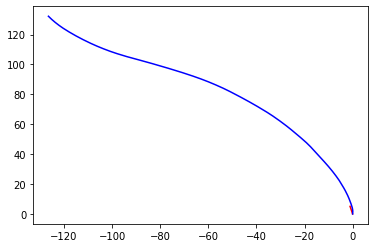

In [ ]:
plt.plot(pts_out[:, 0], pts_out[:, 2], color='red')
plt.plot(pts_yTest[:, 0], pts_yTest[:, 2], color='blue')
plt.show()

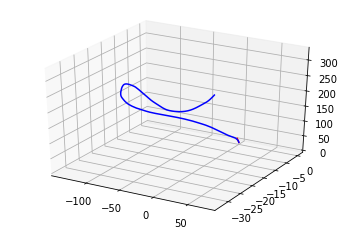

In [ ]:
ax = plt.axes(projection='3d')
ax.plot3D(pts_out[:, 0], pts_out[:, 1], pts_out[:, 2], color='red')
ax.plot3D(pts_yTest[:, 0], pts_yTest[:, 1], pts_yTest[:, 2], color='blue')
plt.show()

(270, 96, 320, 6)
(271, 6)


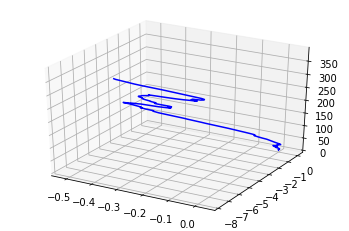

In [ ]:
X_test, y_test_det = VODataLoader(dir_Dataset, attach = False, sequence = '04')
pts_yTest = np.array([[0, 0, 0, 0, 0, 0]])
for i in range(0, len(y_test_det)):
    pts_yTest = np.append(pts_yTest, [pts_yTest[i] + y_test_det[i]], axis=0)

print(pts_yTest.shape)

ax = plt.axes(projection='3d')
ax.plot3D(pts_yTest[:, 0], pts_yTest[:, 1], pts_yTest[:, 2], color='blue')
plt.show()